In [64]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from nionswift_plugin.nionswift_structure_recognition.model import load_preset_model
from nionswift_plugin.nionswift_structure_recognition.scale import RealSpaceCalibrator

from tqdm.auto import tqdm
from psm.graph import stable_delaunay_graph
from psm.rmsd import pairwise_rmsd
from psm.geometry import regular_polygon
from psm.select import select_nodes_in_faces, select_faces_around_nodes
from psm.structures.graphene import defect_fingerprint
from skimage.transform import downscale_local_mean

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
model = load_preset_model('graphene')

In [98]:
cal = RealSpaceCalibrator(model=model,
                               template='hexagonal',
                               lattice_constant=2.46,
                               min_sampling=.01,
                               max_sampling=.1,
                               step_size=.005)

In [129]:
image = np.load('test_5.npy')[2]#, (1,1)) #+ np.random.randn(*image.shape)*4
image.shape

(298, 298)

In [124]:
cal(image)

0.02833796139968223

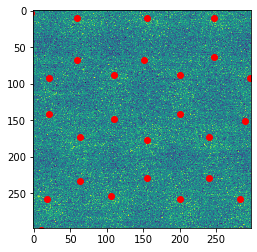

In [130]:

output = model(image, .02833)

points = output['points']
density = output['density']

plt.plot(*points.T,'ro')
plt.imshow(image)
#image.shape

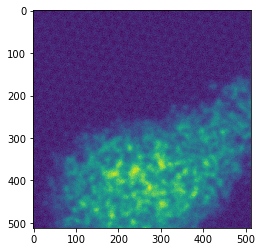

In [5]:
plt.imshow(image)

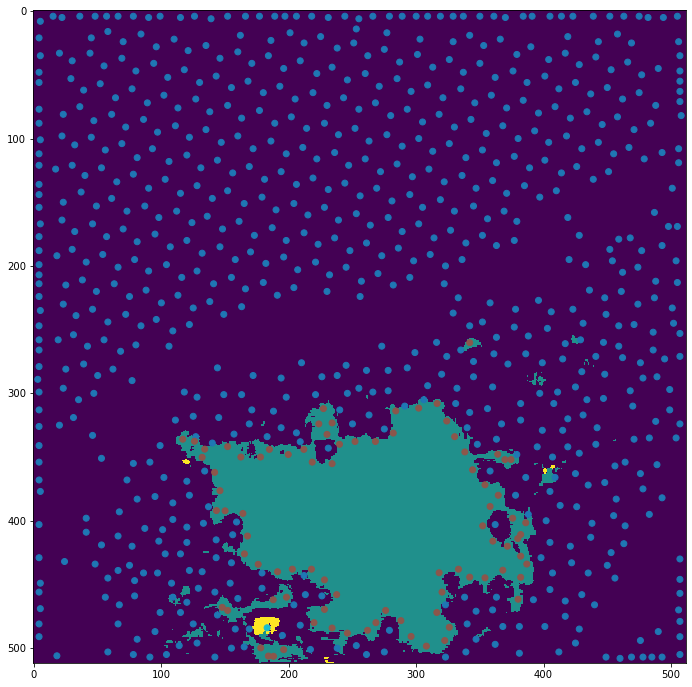

In [17]:
#for i in tqdm(range(100)):
sampling = .1
output = model(image, sampling)

segmentation = output['segmentation']
points = output['points']
labels = output['labels']

plt.figure(figsize=(12,12))
plt.imshow(segmentation)
plt.scatter(*points.T,c=labels,cmap='tab10')

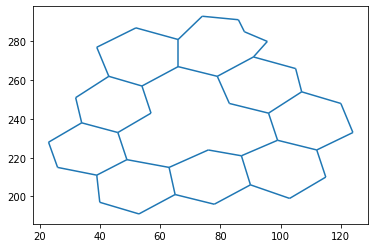

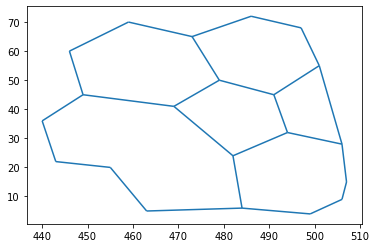

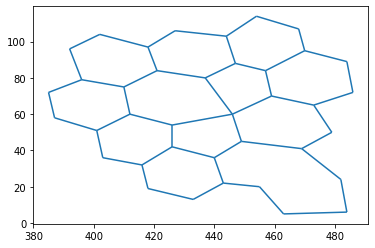

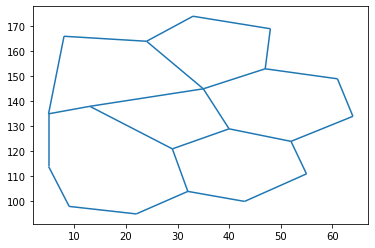

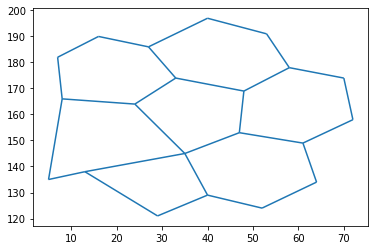

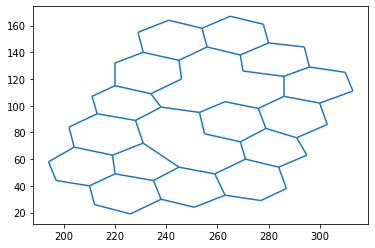

In [390]:
from skimage.measure import find_contours
from skimage.morphology import binary_dilation, binary_erosion, disk
from skimage.transform import rescale
from psm.select import select_faces_around_nodes
from psm.utils import flatten_list_of_lists


points = output['points'].copy()
labels = output['labels'].copy()
#for i in tqdm(range(100)):


segmentation = rescale(output['segmentation'].copy().astype(np.float), .025)
segmentation = np.pad(segmentation, ((1,1),(1,1)))

# contours = find_contours(segmentation.T, .7)
# contours = (np.vstack(contours) - 1) / .025

# points = np.vstack((points, contours))
# labels = np.concatenate((labels, np.full(len(contours), 1)))

graph = stable_delaunay_graph(points, 2)
graph.set_labels(labels)
dual = graph.dual()

contamination_faces = select_faces_around_nodes(np.where(graph.labels==1)[0], graph.faces)
outer_adjacent_faces = flatten_list_of_lists(dual.outer_faces())
invalid_faces = contamination_faces + outer_adjacent_faces

template = regular_polygon(1.42, 6) / sampling
rmsd = pairwise_rmsd([template], graph.face_polygons, B_labels=graph.face_labels).ravel()
defect_faces = rmsd > .07
defect_faces[invalid_faces] = False

defects = []
if np.any(defect_faces):
    dual_defects = dual.subgraph_from_nodes(np.where(defect_faces)[0]).connected_components()

    for dual_defect in dual_defects:
        defect_nodes = select_faces_around_nodes(select_nodes_in_faces(dual_defect.member_nodes, graph.faces), graph.faces)
        defect = graph.subgraph_from_faces(defect_nodes).detach()
        
        dual = defect.dual()
        
        if len(dual.faces) == 0:
            continue    
        
        defects.append({})
        defects[-1]['graph'] = defect
        defects[-1]['dual'] = dual
        
        fig,ax=plt.subplots(1,1)
        defect.plot(ax)
        #defects[-1]['dual'].plot()
        plt.show()
        
        defects[-1]['enclosing_path'] = defects[-1]['dual'].outer_face_polygons()[0]
        defects[-1]['contamination'] = len(set(contamination_faces).intersection(defect_nodes)) > 0
        defects[-1]['outside'] = len(set(outer_adjacent_faces).intersection(defect_nodes)) > 0

        defects[-1]['signature'] = 'none'
        if (not defects[-1]['contamination']) & (not defects[-1]['outside']):
            try:
                defects[-1]['signature'] = defect_fingerprint(defect, True)
            except RuntimeError:
                pass

#defects

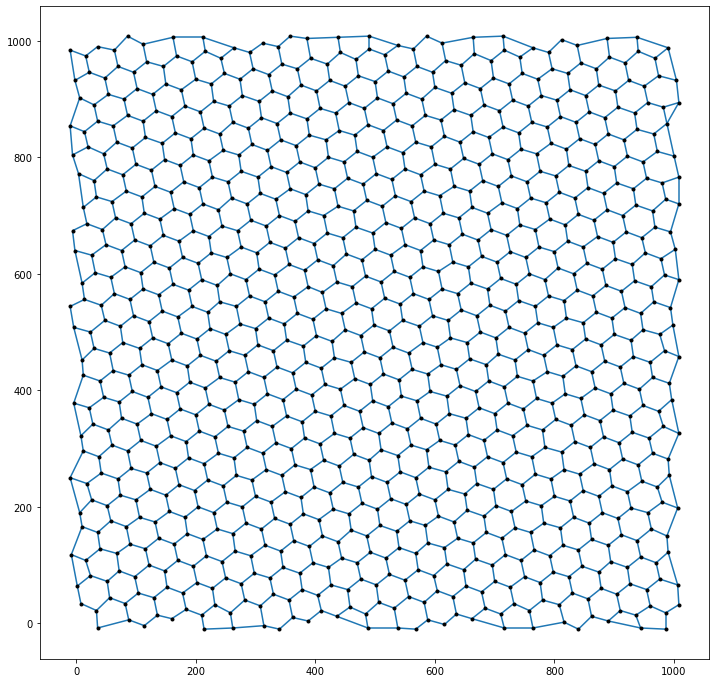

In [261]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
graph.plot(ax=ax)
#graph.dual().plot(ax=ax)

ax.plot(*graph.points.T,'k.')
#ax.plot(*dual.points[contamination_faces].T, 'ro')
#ax.plot(*dual.points[outer_adjacent_faces].T, 'go')
# #ax.imshow(image)

# for face in dual.outer_faces():
#     ax.plot(*dual.points[face].T,'o')

# for i, p in enumerate(dual.points):
#     ax.annotate('{}'.format(i), xy=p)

for defect in defects:
    if not (defect['contamination'] + defect['outside']):
        ax.plot(*defect['enclosing_path'].T,'m-',linewidth=4)
    else:
        ax.plot(*defect['enclosing_path'].T,'g-',linewidth=4)
    #ax.plot(*defect['graph'].points.T,'mo')
    #ax.plot(*defect['dual'].points.T,'go')
    
    #ax.plot(*defect.points.T,'yo')

In [ ]:


#contamination = output['segmentation'] == 0

#contamination = F.interpolate(contamination, scale_factor=1/4)
#contamination = F.max_pool2d(contamination, 3, 1, padding=1) - contamination

#contamination = contamination[0,0].detach().cpu().numpy()


#print(points)
#contamination_points = np.array(np.where(contamination)).T * 4
#print(contamination_points)

#plt.figure(figsize=(12,12))

#plt.plot(*points.T,'ro')
#plt.plot(*contamination_points.T,'bo')